## Remember to open terminal and run: conda activate ilab-tensorflow to import shap

In [2]:
import shap

In [3]:
import sys
sys.path.append('/explore/nobackup/people/gtamkin/dev/AGB/mpf-model-factories/MultiPathFusion')

In [4]:
from multi_path_fusion.src.training.train_gt import train

from multi_path_fusion.src.utils.mlflow_helpers import setup_mlflow, log_params
from multi_path_fusion.src.utils.data_generator_helpers import load_data_generator
from multi_path_fusion.src.utils.model_helpers import get_model_factory

2023-10-30 13:27:06.154617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 13:27:06.236351: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [5]:
from tensorflow import keras
import json
import matplotlib.pyplot as plt
import numpy as np
import mlflow
import rasterio

In [6]:
with open('../../config/config_gt_1model_1band.json', 'r') as f:
    config = json.load(f)
    models_config = config["models"]
    data_generator_config = config["data_generator"]
    mlflow_config = config["mlflow"]

In [7]:
model_config = models_config[0]

mlflow_config = setup_mlflow(mlflow_config)


2023-10-30 13:27:10.489865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


reading in band: 18
reading in band: 14
reading in band: 9
reading in band: 3
reading in band: 20
reading in band: 8
reading in band: 10
reading in band: 18
reading in band: 14
reading in band: 9
reading in band: 3
reading in band: 20
reading in band: 8
reading in band: 10
reading in band: 18
reading in band: 14
reading in band: 9
reading in band: 3
reading in band: 20
reading in band: 8
reading in band: 10
STARTING RUN: 95715e8f52434bfea6f35a0c7784cf77
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 64        
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
Total params: 109
Trainable params: 109
Non-trainable params: 0
______________________________________________________________

2023/10/30 13:27:34 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'multi_path_fusion.src.data_generators.mpf_h_data_generator.MPF_H_DataGenerator'>. Dataset logging skipped.
2023/10/30 13:27:34 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'multi_path_fusion.src.data_generators.mpf_h_data_generator.MPF_H_DataGenerator'>. Dataset logging skipped.


Epoch 1/2
16000/16000 [==============================] - 14s 823us/step - loss: 1.4851 - accuracy: 0.3555 - val_loss: 1.4915 - val_accuracy: 0.3415
Epoch 2/2
16000/16000 [==============================] - 13s 821us/step - loss: 1.4728 - accuracy: 0.3606 - val_loss: 1.4772 - val_accuracy: 0.3560


2023/10/30 13:28:03 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2023/10/30 13:28:03 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2023/10/30 13:28:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."



Total time for model.fit() processing is: 36.366456031799316 seconds.
2000/2000 [==============================] - 1s 717us/step - loss: 1.4694 - accuracy: 0.3578
predictions: [[0.14554211 0.17060475 0.3359131  0.24087924 0.1070608 ]
 [0.18027392 0.16312845 0.303894   0.24395968 0.10874392]
 [0.09792534 0.15123512 0.34832597 0.2971675  0.10534614]
 ...
 [0.28860736 0.17089659 0.2586895  0.18068913 0.10111748]
 [0.32752484 0.17356588 0.24545275 0.15597081 0.09748569]
 [0.45011577 0.15815076 0.19084255 0.11515333 0.08573751]]
test results: {'test loss': 1.4694066047668457, 'test accuracy': 0.35776999592781067}
2000/2000 [==============================] - 1s 688us/step
Finished successfully


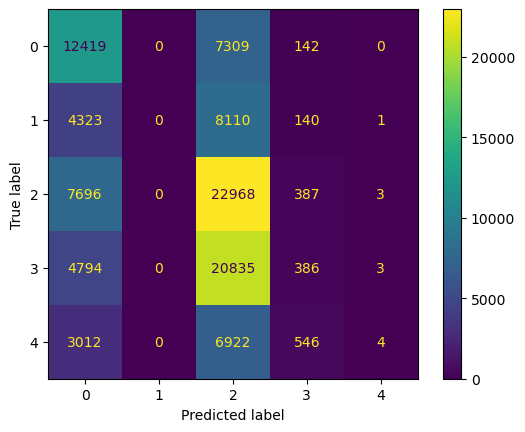

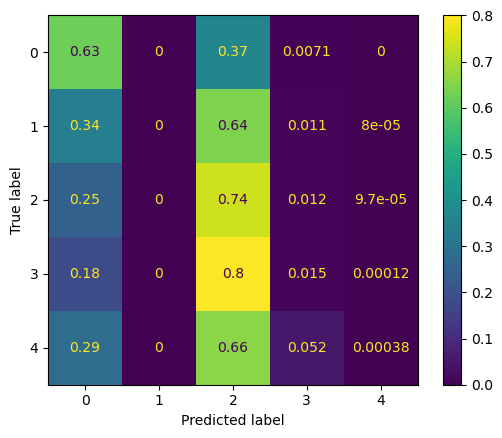

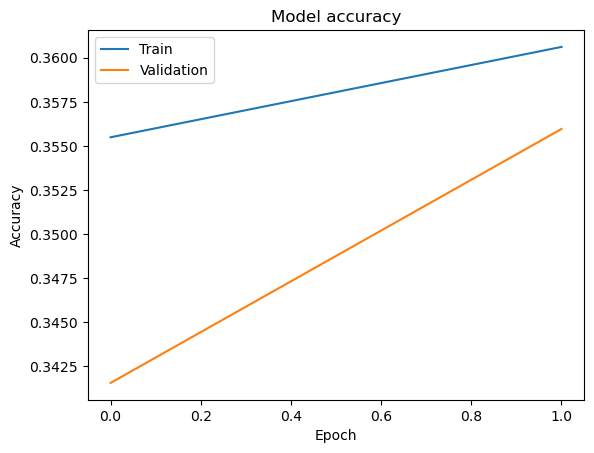

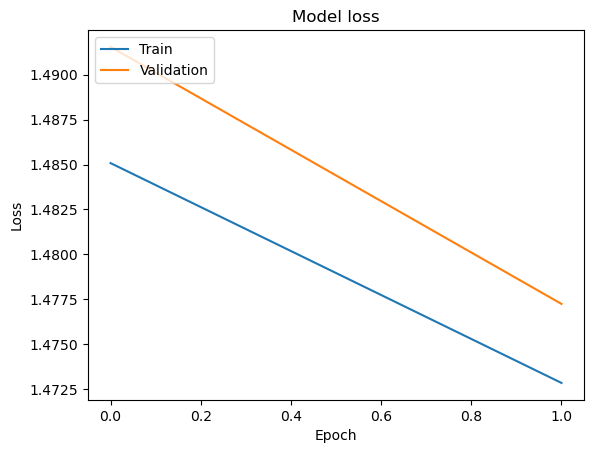

In [8]:
    import time  
    
    model_type = model_config.get("model_type", "Sequential")  
    model_factory = get_model_factory(model_type)  
    model = model_factory.create_model(model_config, data_generator_config)
    model = model_factory.compile_model(model, model_config)

    # TODO: potentially add an option for being able to load in a previous model 
    # (such as using an encoder previously and training on the latent space instead of the original data)

    train_generator = load_data_generator(data_generator_config, 'train')
    validate_generator = load_data_generator(data_generator_config, 'validate')
    test_generator = load_data_generator(data_generator_config, 'test')

    # probably not needed - will delete soon
    # run_name = get_unique_run_name(mlflow_config, model_config.get('model_name', None))
    with mlflow.start_run(experiment_id=mlflow_config['EXPERIMENT_ID'], run_name=model_config.get("model_name", None), description=model_config.get("model_description", ""), nested=False) as run:
        model_factory.autolog()
        log_params(model_config)
        RUN_ID = mlflow.active_run().info.run_id
        print(f"STARTING RUN: {RUN_ID}")
        
        # TODO: figure out best spot to put this function in, or if there needs to be multiple
        # "extras" depending on where in the training flow you want it to occur
        # put any miscellaneous project-specific code here
        model_factory.extras(model, train_generator, validate_generator, test_generator)

        t0 = time.time()

        # TODO: figure out a way to make this if statement more generic 
        # problem is keras model summary best done before training, xgboost summary only able to be done after
        if model_type == "Sequential" or "Keras":
            model_factory.summary(model)
        history = model_factory.train_model(model, train_generator, validate_generator, model_config)

        t1 = time.time()
        total_time = t1 - t0

        mlflow.log_param("Training time", total_time)

        print()
        print("Total time for model.fit() processing is: " + str(total_time) + " seconds.")

        if model_type == "XGBoost":
            model_factory.summary(model)

        predictions = model_factory.predict(model, test_generator)
        test_results = model_factory.evaluate(model, test_generator)
        
        # debugging
        print(f'predictions: {predictions}')
        print(f'test results: {test_results}')

        model_factory.log_metrics(test_results)
        model_factory.plot_metrics(model, test_generator, history)

        
        # debugging
        print("Finished successfully")


In [9]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 64        
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
Total params: 109
Trainable params: 109
Non-trainable params: 0
_________________________________________________________________
None


*** SHAP *********

In [10]:
#!pip install shap

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

In [12]:
X,y = load_diabetes(return_X_y=True)
features = load_diabetes()['feature_names']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:
X_train, X_test, y_train, y_test 

(array([[ 0.0090156 , -0.04464164, -0.03099563, ..., -0.00259226,
          0.00943366,  0.01134862],
        [-0.00188202, -0.04464164,  0.05415152, ...,  0.08486339,
          0.08449153,  0.04862759],
        [ 0.0090156 ,  0.05068012, -0.00512814, ...,  0.07120998,
          0.03954249,  0.01963284],
        ...,
        [ 0.03081083, -0.04464164, -0.02021751, ..., -0.03949338,
         -0.01090325, -0.0010777 ],
        [-0.01277963, -0.04464164, -0.02345095, ..., -0.00259226,
         -0.03845972, -0.03835666],
        [-0.09269548, -0.04464164,  0.02828403, ..., -0.03949338,
         -0.00514219, -0.0010777 ]]),
 array([[ 0.04534098, -0.04464164, -0.00620595, ...,  0.03430886,
          0.03243232, -0.0052198 ],
        [ 0.09256398, -0.04464164,  0.03690653, ..., -0.03949338,
         -0.02251653, -0.02178823],
        [ 0.06350368,  0.05068012, -0.00405033, ..., -0.00259226,
          0.08449153, -0.01764613],
        ...,
        [-0.07453279, -0.04464164, -0.046085  , ..., -

In [14]:
model = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(5,),activation='logistic', max_iter=10000,learning_rate='invscaling',random_state=0)
)

In [16]:
model.fit(X_train,y_train)

Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(activation='logistic', hidden_layer_sizes=(5,),
                              learning_rate='invscaling', max_iter=10000,
                              random_state=0))])

In [17]:
explainer = shap.KernelExplainer(model.predict,X_train)

Using 296 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
print(model.layers[0].output())
print(model.layers[1].output())

In [ ]:
initial_model = model
feature_extractor = keras.Model(
    inputs=initial_model.inputs,
    outputs=[layer.output for layer in initial_model.layers],
)


In [ ]:
# Call feature extractor on test input.
x = tf.ones((2,7))
features = feature_extractor(x)

In [ ]:
print(features)

In [ ]:
extract = keras.Model(model.inputs, model.layers[-2].output) # Dense(128,...)
features = extract.predict(test_generator)
print(features)

In [ ]:
import tensorflow as tf

In [ ]:
model.test_on_batch(test_generator)